# 02 - Data Visualization

LMDB'den veri yükleme ve 3D volume görselleştirme.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from src.utils.config import get_config
from src.data.dataset import VesuviusLMDBDataset

cfg = get_config()
print(f"Config loaded")

Config loaded


## 1. Dataset Yükleme

In [2]:
# LMDB Dataset yükle
lmdb_path = cfg.path('train_lmdb')
print(f"LMDB path: {lmdb_path}")

dataset = VesuviusLMDBDataset(lmdb_path, split='all')
print(f"Dataset size: {len(dataset)}")
print(f"Scroll IDs: {dataset.get_scroll_ids()}")

LMDB path: /Users/enesdemir/Documents/Vesuvius_Challenge_Surface_Detection/dataset/processed/train.lmdb
Dataset size: 786
Scroll IDs: [26002, 26010, 34117, 35360, 44430, 53997]


## 2. İlk 2 Volume'u Yükle

In [3]:
# İlk 2 sample'ı yükle
sample1 = dataset[0]
sample2 = dataset[1]

print("=" * 50)
print("SAMPLE 1")
print("=" * 50)
print(f"Volume ID: {sample1['id']}")
print(f"Scroll ID: {sample1['scroll_id']}")
print(f"Image shape: {sample1['image'].shape}")
print(f"Image dtype: {sample1['image'].dtype}")
print(f"Image min/max: {sample1['image'].min():.2f} / {sample1['image'].max():.2f}")
print(f"Label shape: {sample1['label'].shape}")
print(f"Label unique values: {sample1['label'].unique().tolist()}")
print(f"Has label: {sample1['has_label']}")

print("\n" + "=" * 50)
print("SAMPLE 2")
print("=" * 50)
print(f"Volume ID: {sample2['id']}")
print(f"Scroll ID: {sample2['scroll_id']}")
print(f"Image shape: {sample2['image'].shape}")
print(f"Image min/max: {sample2['image'].min():.2f} / {sample2['image'].max():.2f}")
print(f"Label unique values: {sample2['label'].unique().tolist()}")

SAMPLE 1
Volume ID: 2290837
Scroll ID: 34117
Image shape: torch.Size([320, 320, 320])
Image dtype: torch.float32
Image min/max: 0.00 / 255.00
Label shape: torch.Size([320, 320, 320])
Label unique values: [0, 1, 2]
Has label: True

SAMPLE 2
Volume ID: 3320274
Scroll ID: 35360
Image shape: torch.Size([320, 320, 320])
Image min/max: 0.00 / 255.00
Label unique values: [0, 1, 2]


## 3. 3D Volume Görselleştirme

Ortho slices: XY, XZ, YZ düzlemlerinden kesitler

In [4]:
def visualize_volume(image, label, vol_id, scroll_id, slice_idx=None):
    """3D volume'un ortho slice görünümü."""
    image = image.numpy()
    label = label.numpy()
    
    D, H, W = image.shape
    if slice_idx is None:
        slice_idx = D // 2  # Orta slice
    
    # Label colormap: 0=black, 1=red, 2=gray
    label_cmap = ListedColormap(['black', 'red', 'gray'])
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Volume: {vol_id} | Scroll: {scroll_id} | Slice: {slice_idx}", fontsize=14)
    
    # Row 1: Image slices
    axes[0, 0].imshow(image[slice_idx, :, :], cmap='gray')
    axes[0, 0].set_title(f'Image XY (z={slice_idx})')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(image[:, H//2, :], cmap='gray', aspect='auto')
    axes[0, 1].set_title(f'Image XZ (y={H//2})')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(image[:, :, W//2], cmap='gray', aspect='auto')
    axes[0, 2].set_title(f'Image YZ (x={W//2})')
    axes[0, 2].axis('off')
    
    # Row 2: Label slices
    axes[1, 0].imshow(label[slice_idx, :, :], cmap=label_cmap, vmin=0, vmax=2)
    axes[1, 0].set_title(f'Label XY (z={slice_idx})')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(label[:, H//2, :], cmap=label_cmap, vmin=0, vmax=2, aspect='auto')
    axes[1, 1].set_title(f'Label XZ (y={H//2})')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(label[:, :, W//2], cmap=label_cmap, vmin=0, vmax=2, aspect='auto')
    axes[1, 2].set_title(f'Label YZ (x={W//2})')
    axes[1, 2].axis('off')
    
    # Legend
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', label='Background (0)', markerfacecolor='black', markersize=15),
        plt.Line2D([0], [0], marker='s', color='w', label='Foreground (1)', markerfacecolor='red', markersize=15),
        plt.Line2D([0], [0], marker='s', color='w', label='Unlabeled (2)', markerfacecolor='gray', markersize=15)
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

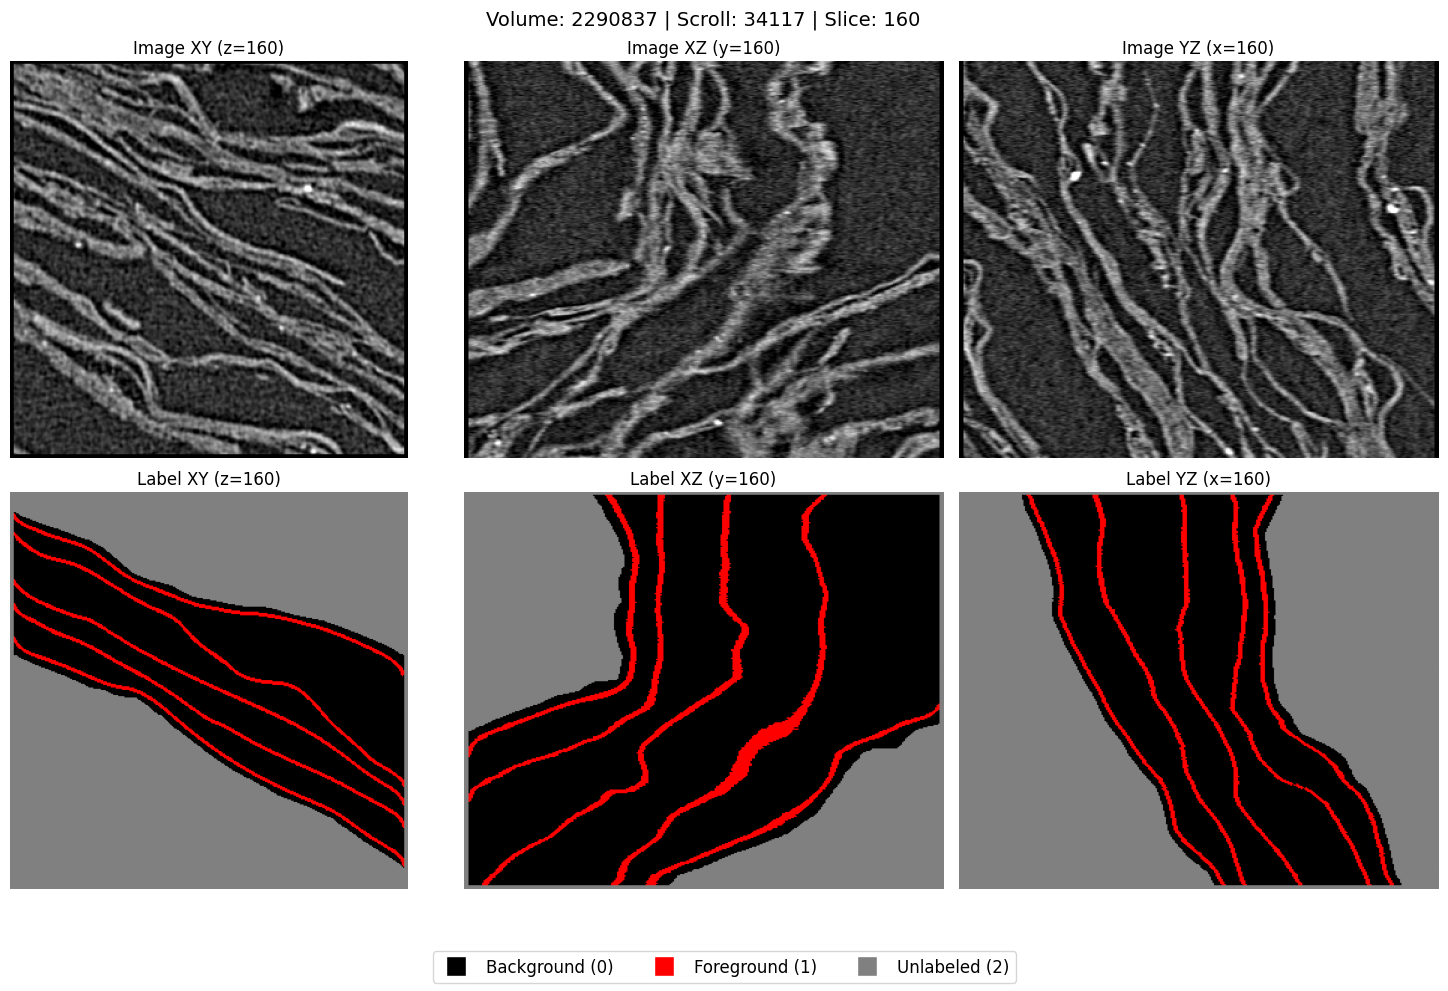

In [5]:
# Sample 1 görselleştir
visualize_volume(sample1['image'], sample1['label'], sample1['id'], sample1['scroll_id'])

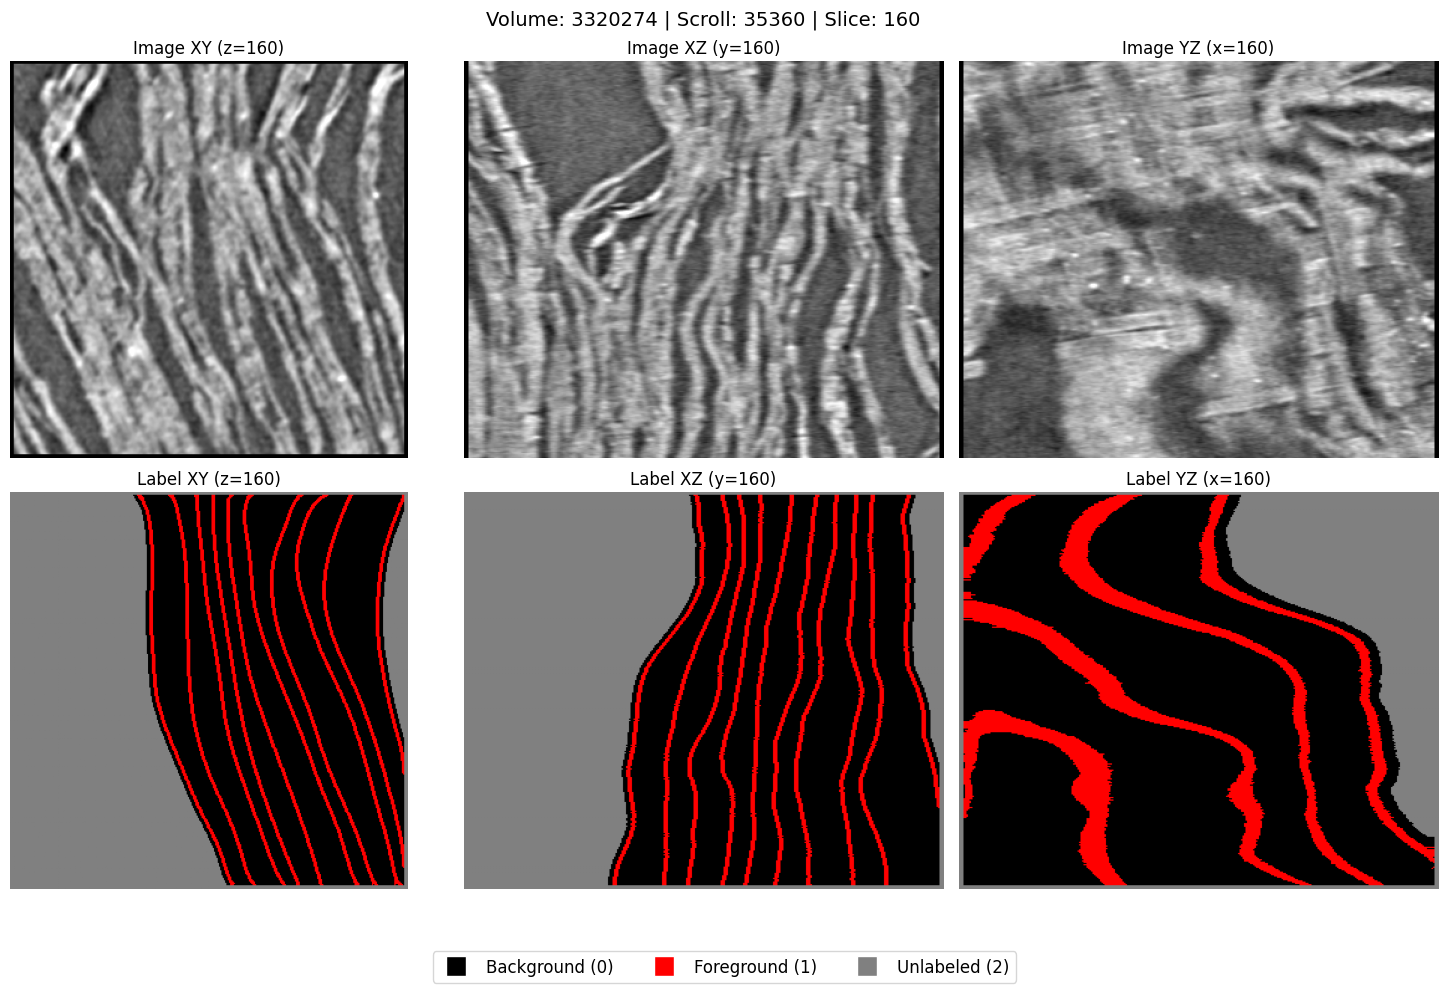

In [6]:
# Sample 2 görselleştir
visualize_volume(sample2['image'], sample2['label'], sample2['id'], sample2['scroll_id'])

## 4. Image + Label Overlay

In [7]:
def visualize_overlay(image, label, vol_id, slice_indices=None, alpha=0.5):
    """Image üzerine label overlay."""
    image = image.numpy()
    label = label.numpy()
    
    D, H, W = image.shape
    if slice_indices is None:
        slice_indices = [D//4, D//2, 3*D//4]  # 3 farklı derinlik
    
    fig, axes = plt.subplots(2, len(slice_indices), figsize=(5*len(slice_indices), 10))
    fig.suptitle(f"Volume: {vol_id} - Overlay View", fontsize=14)
    
    for i, z in enumerate(slice_indices):
        img_slice = image[z]
        lbl_slice = label[z]
        
        # Normalize image to [0, 1]
        img_norm = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + 1e-8)
        
        # Create RGB image
        rgb = np.stack([img_norm, img_norm, img_norm], axis=-1)
        
        # Create overlay
        overlay = rgb.copy()
        # Foreground (1) = Red
        overlay[lbl_slice == 1] = [1, 0, 0]
        # Blend
        blended = (1 - alpha) * rgb + alpha * overlay
        blended = np.clip(blended, 0, 1)
        
        # Top row: Original
        axes[0, i].imshow(img_slice, cmap='gray')
        axes[0, i].set_title(f'Original (z={z})')
        axes[0, i].axis('off')
        
        # Bottom row: Overlay
        axes[1, i].imshow(blended)
        axes[1, i].set_title(f'Overlay (z={z})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

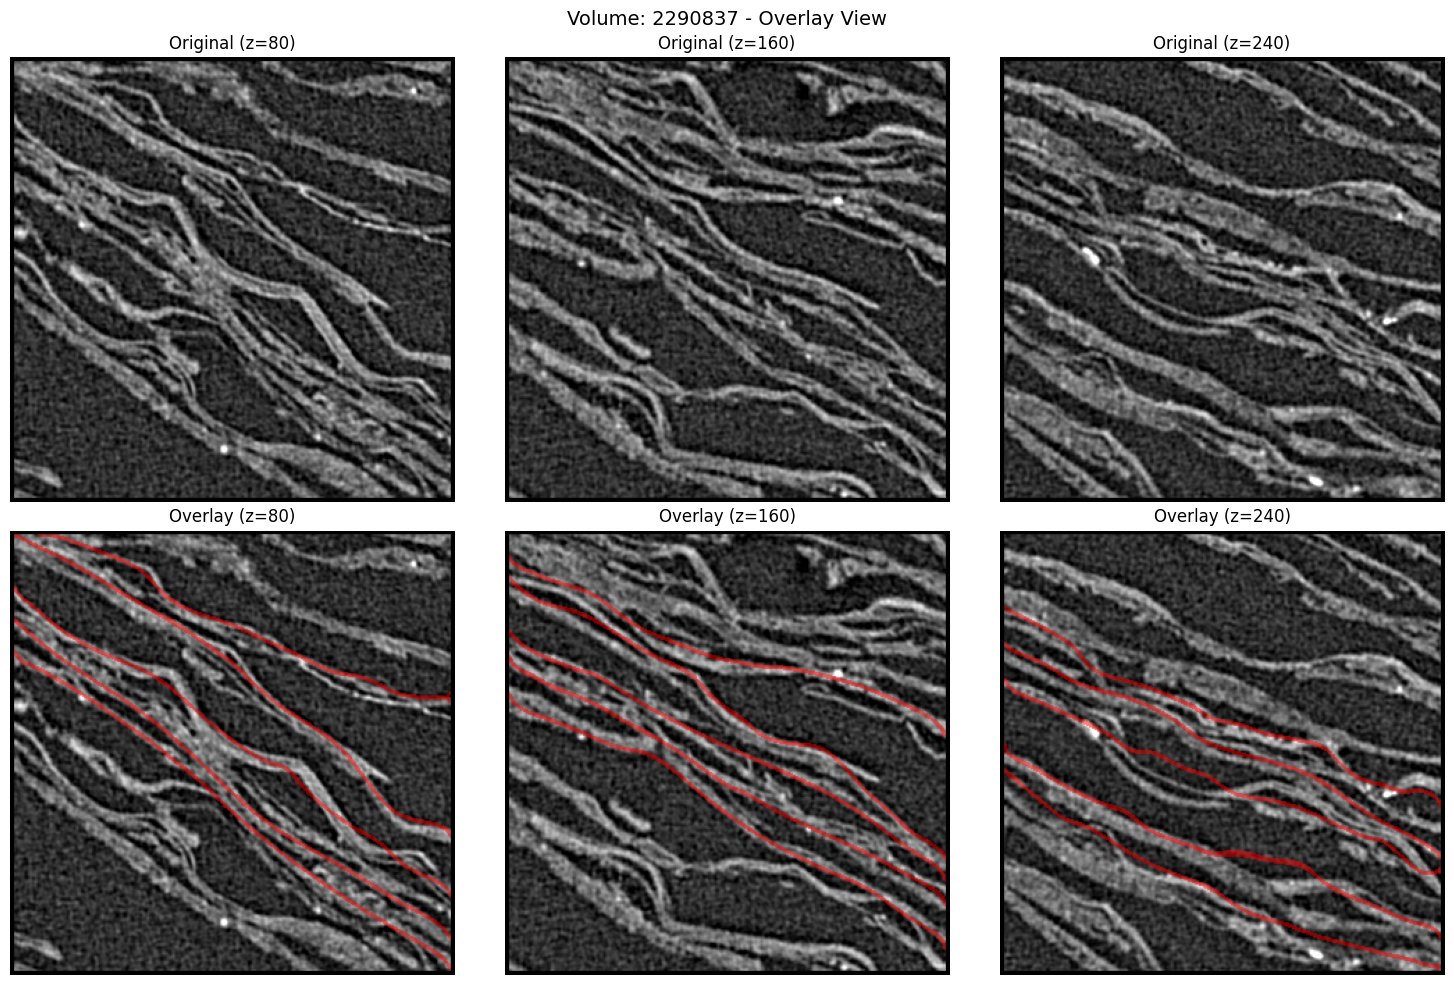

In [8]:
visualize_overlay(sample1['image'], sample1['label'], sample1['id'])

## 5. Class Distribution Analysis

In [9]:
def analyze_class_distribution(samples, sample_names):
    """Birden fazla sample için class dağılımı."""
    fig, axes = plt.subplots(1, len(samples), figsize=(5*len(samples), 4))
    if len(samples) == 1:
        axes = [axes]
    
    for ax, sample, name in zip(axes, samples, sample_names):
        label = sample['label'].numpy()
        vals, counts = np.unique(label, return_counts=True)
        total = counts.sum()
        pcts = counts / total * 100
        
        colors = ['black', 'red', 'gray']
        labels = ['Background', 'Foreground', 'Unlabeled']
        
        bars = ax.bar([labels[v] for v in vals], pcts, color=[colors[v] for v in vals], edgecolor='white')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(f'{name}')
        
        for bar, pct in zip(bars, pcts):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{pct:.1f}%', ha='center', fontsize=10)
    
    plt.suptitle('Class Distribution per Volume', fontsize=14)
    plt.tight_layout()
    plt.show()

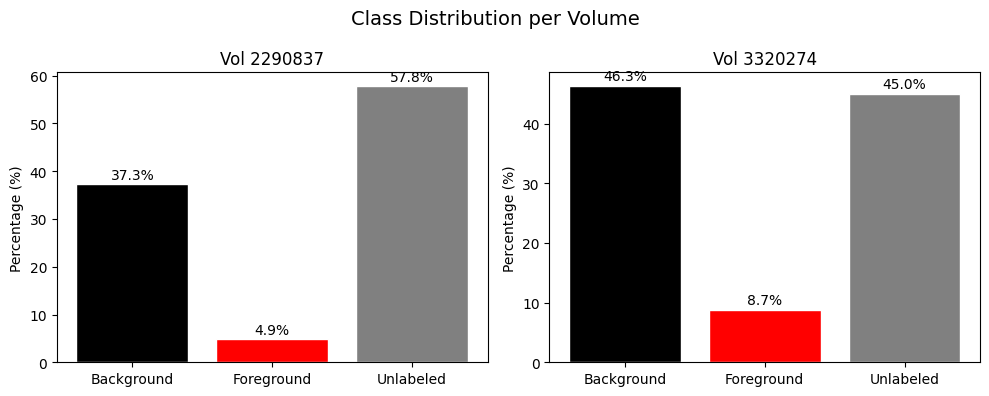

In [10]:
analyze_class_distribution(
    [sample1, sample2], 
    [f"Vol {sample1['id']}", f"Vol {sample2['id']}"]
)

## 6. Intensity Histogram

In [11]:
def plot_intensity_histogram(samples, sample_names):
    """Image intensity dağılımı."""
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for sample, name in zip(samples, sample_names):
        image = sample['image'].numpy().flatten()
        ax.hist(image, bins=100, alpha=0.6, label=name, density=True)
    
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Density')
    ax.set_title('Image Intensity Distribution')
    ax.legend()
    plt.tight_layout()
    plt.show()

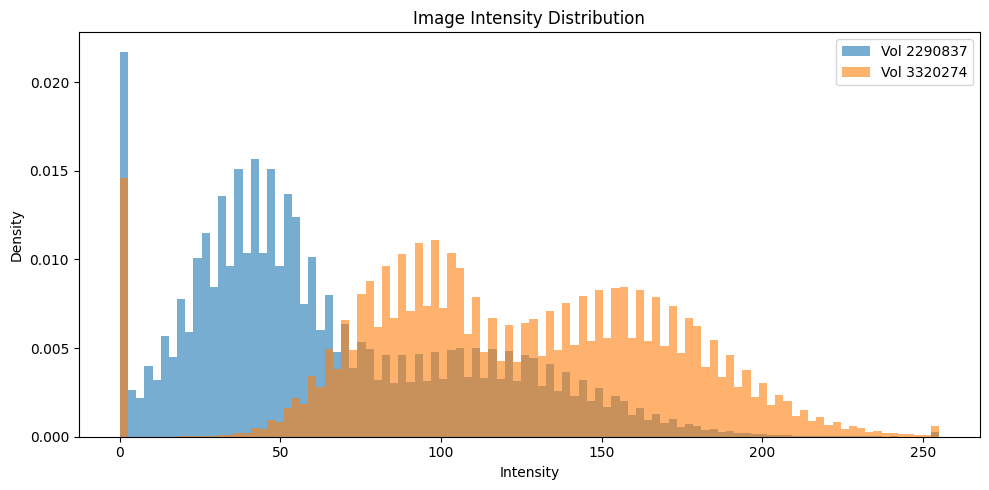

In [12]:
plot_intensity_histogram(
    [sample1, sample2],
    [f"Vol {sample1['id']}", f"Vol {sample2['id']}"]
)

## 7. Foreground Distribution per Slice

In [13]:
def plot_foreground_per_slice(sample, vol_id):
    """Her slice'ta foreground pixel sayısı."""
    label = sample['label'].numpy()
    D = label.shape[0]
    
    fg_counts = [(label[z] == 1).sum() for z in range(D)]
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.fill_between(range(D), fg_counts, alpha=0.7, color='red')
    ax.plot(fg_counts, color='darkred', linewidth=1)
    ax.set_xlabel('Slice Index (z)')
    ax.set_ylabel('Foreground Pixel Count')
    ax.set_title(f'Foreground Distribution per Slice - Vol {vol_id}')
    ax.set_xlim(0, D-1)
    plt.tight_layout()
    plt.show()

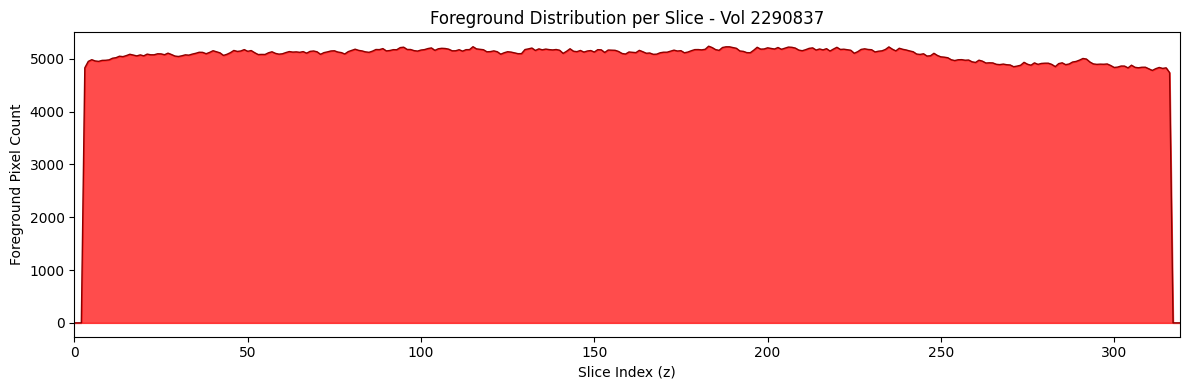

In [14]:
plot_foreground_per_slice(sample1, sample1['id'])

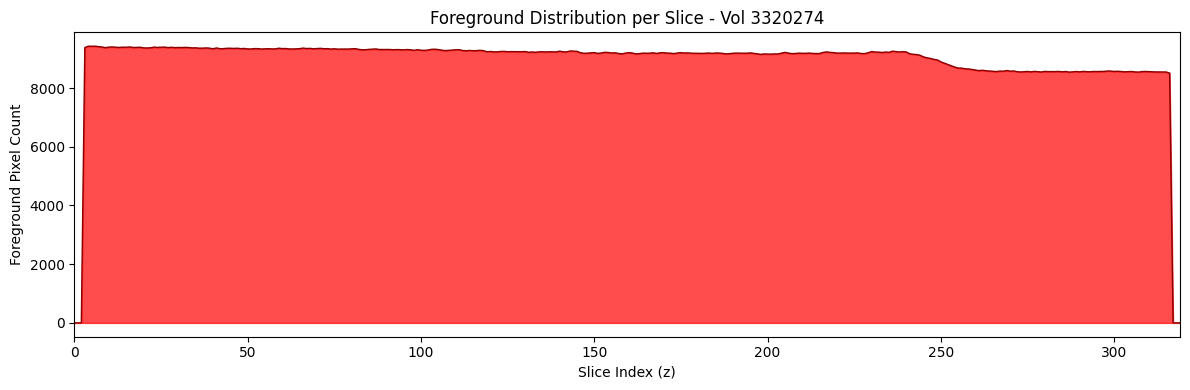

In [15]:
plot_foreground_per_slice(sample2, sample2['id'])

## 8. Train/Val Split Visualization

In [16]:
# Scroll-based split
train_ds = VesuviusLMDBDataset(lmdb_path, split='train')
val_ds = VesuviusLMDBDataset(lmdb_path, split='val')

print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Train scrolls: {train_ds.get_scroll_ids()}")
print(f"Val scrolls: {val_ds.get_scroll_ids()}")

Train size: 616
Val size: 170
Train scrolls: [26002, 26010, 34117, 44430, 53997]
Val scrolls: [35360]


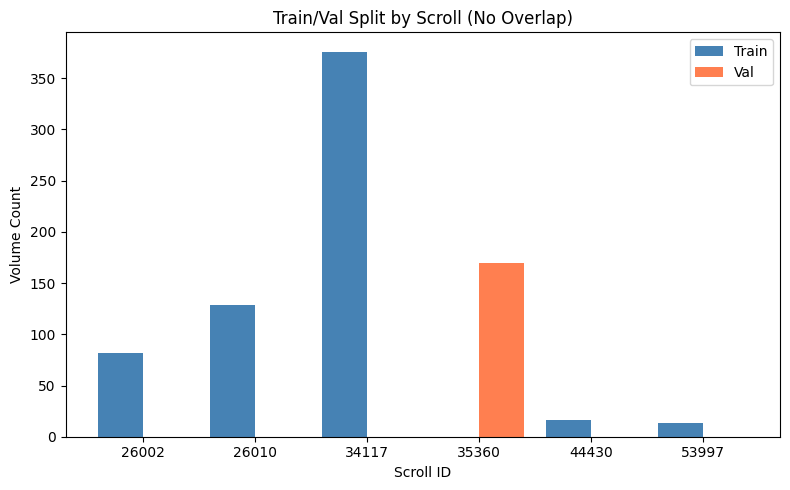

In [17]:
# Split görselleştirme
fig, ax = plt.subplots(figsize=(8, 5))

train_scrolls = train_ds.get_scroll_ids()
val_scrolls = val_ds.get_scroll_ids()

# Count volumes per scroll
train_counts = {sid: len(train_ds.get_volumes_by_scroll(sid)) for sid in train_scrolls}
val_counts = {sid: len(val_ds.get_volumes_by_scroll(sid)) for sid in val_scrolls}

all_scrolls = sorted(set(train_scrolls) | set(val_scrolls))
x = np.arange(len(all_scrolls))

train_vals = [train_counts.get(s, 0) for s in all_scrolls]
val_vals = [val_counts.get(s, 0) for s in all_scrolls]

ax.bar(x - 0.2, train_vals, 0.4, label='Train', color='steelblue')
ax.bar(x + 0.2, val_vals, 0.4, label='Val', color='coral')

ax.set_xlabel('Scroll ID')
ax.set_ylabel('Volume Count')
ax.set_title('Train/Val Split by Scroll (No Overlap)')
ax.set_xticks(x)
ax.set_xticklabels(all_scrolls)
ax.legend()

plt.tight_layout()
plt.show()